In [6]:
# === 1. Necessary Imports ====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K



In [8]:
df=pd.read_csv("FourRegionData.csv")
df.head(10)

,Region,Year,Month,SoilTemperature-10,SoilTemperature-30,SoilTemperature-50,Rainfall,Temperature,Min Temperature,Max Temperature,Humidity,Sunshine,Wind Speed,Surface Pressure,Solar Radiation
0,2,2001,1,17.40,18.81,19.43,0,18.38,13.04,25.44,62.68,7.94,2.17,101268.29,199.25
1,2,2001,2,19.88,19.98,20.36,1,22.61,16.90,28.56,61.71,7.19,1.98,101039.08,210.73
2,2,2001,3,24.08,23.32,23.17,33,26.62,20.73,31.84,55.48,8.75,2.10,100882.56,251.75
3,2,2001,4,27.62,27.02,26.77,46,29.06,24.71,32.06,65.63,8.55,2.70,100655.40,257.46
4,2,2001,5,28.54,28.29,28.21,402,27.69,24.18,32.09,77.39,6.10,2.37,100234.63,172.32
5,2,2001,6,30.11,29.82,29.64,386,28.03,25.55,31.75,83.17,3.51,3.64,99934.18,140.45
6,2,2001,7,30.74,30.53,30.64,202,28.83,25.92,31.60,80.26,4.55,3.87,99991.05,169.40
7,2,2001,8,30.99,30.99,30.86,205,29.46,25.23,31.50,82.19,5.15,3.01,100129.68,181.66
8,2,2001,9,29.83,29.89,29.95,209,28.71,24.34,32.42,82.53,4.65,2.14,100499.17,170.22
9,2,2001,10,28.00,28.29,28.50,177,27.63,22.83,31.44,80.45,5.60,1.59,100864.38,167.89


In [16]:


features = df[['Month', 'Temperature', 'Min Temperature',
               'Max Temperature', 'Surface Pressure']]
target = df['SoilTemperature-50']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))


def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

WINDOW = 3
X_seq, y_seq = create_sliding_window(X_scaled, y_scaled, WINDOW)

total_samples = len(X_seq)
train_end = int(0.7 * total_samples)
val_end = int(0.85 * total_samples)

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test = X_seq[val_end:], y_seq[val_end:]

model = Sequential([
    
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1) 
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])




early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
lr_sched = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_sched],
    verbose=1
)


results = model.evaluate(X_test, y_test, verbose=0)
loss = results[0]
mae = results[1]
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE:       {mae:.4f}")


y_pred_scaled = model.predict(X_test)
y_pred        = tgt_scaler.inverse_transform(y_pred_scaled)
y_true        = tgt_scaler.inverse_transform(y_test)

comparison = pd.DataFrame({
    'Predicted': y_pred.flatten(),
    'Actual':    y_true.flatten()
})
print(comparison.head(14))


Epoch 1/100
24/24 [==============================] - 5s 49ms/step - loss: 0.2535 - mae: 0.4366 - val_loss: 0.0305 - val_mae: 0.1522 - lr: 0.0010
Epoch 2/100
11/24 [============>.................] - ETA: 0s - loss: 0.0430 - mae: 0.1685

C:\Users\HP Laptop 15\tfenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 11ms/step - loss: 0.0334 - mae: 0.1468 - val_loss: 0.0106 - val_mae: 0.0836 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0205 - mae: 0.1094 - val_loss: 0.0071 - val_mae: 0.0670 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0206 - mae: 0.1086 - val_loss: 0.0059 - val_mae: 0.0586 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0152 - mae: 0.0944 - val_loss: 0.0058 - val_mae: 0.0590 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0160 - mae: 0.0960 - val_loss: 0.0054 - val_mae: 0.0573 - lr: 0.0010
Epoch 7/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0157 - mae: 0.0977 - val_loss: 0.0052 - val_mae: 0.0518 - lr: 0.0010
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0144 - mae: 0.0913 - val_loss: 0.0060 - val_mae: 0.0578 - lr: 0.001

In [ ]:
WINDOW = 12
Test Loss (MSE): 0.0097
Test MAE:       0.0839

WINDOW = 9
Test Loss (MSE): 0.0138
Test MAE:       0.1010


WINDOW = 6
Test Loss (MSE): 0.0082
Test MAE:       0.0746

WINDOW = 3
Test Loss (MSE): 0.0067
Test MAE:       0.0670

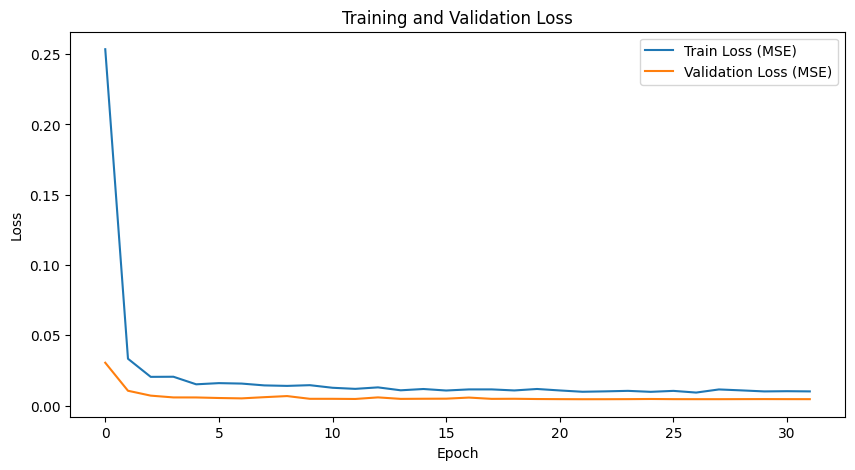

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

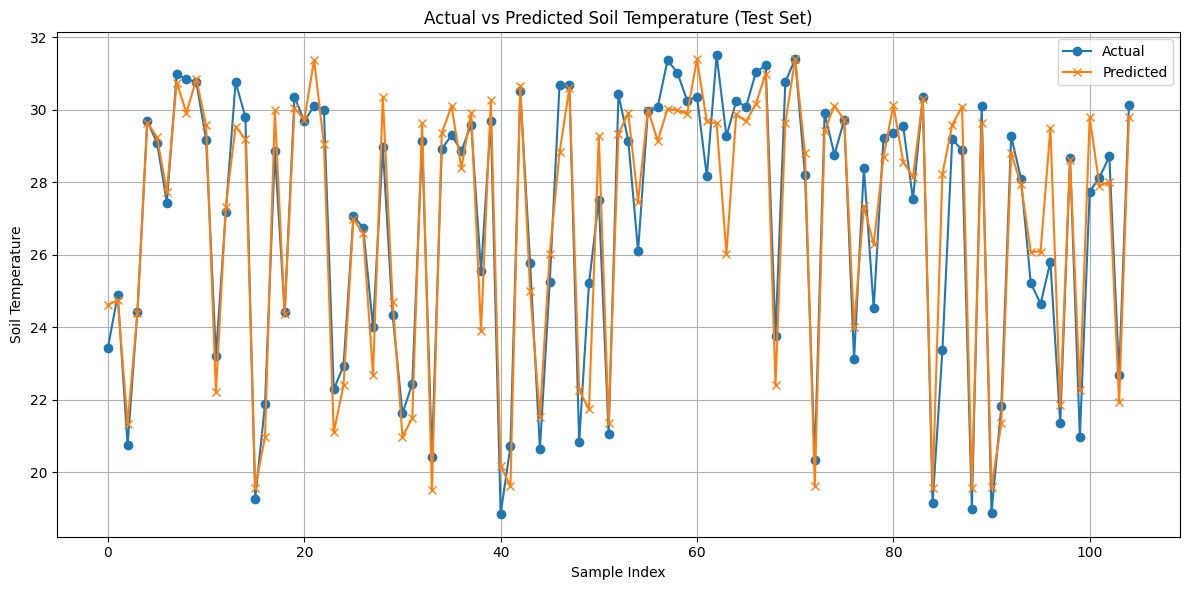

In [11]:


plt.figure(figsize=(12, 6))
plt.plot(comparison['Actual'].values, label='Actual', marker='o')
plt.plot(comparison['Predicted'].values, label='Predicted', marker='x')
plt.title('Actual vs Predicted Soil Temperature (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Soil Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


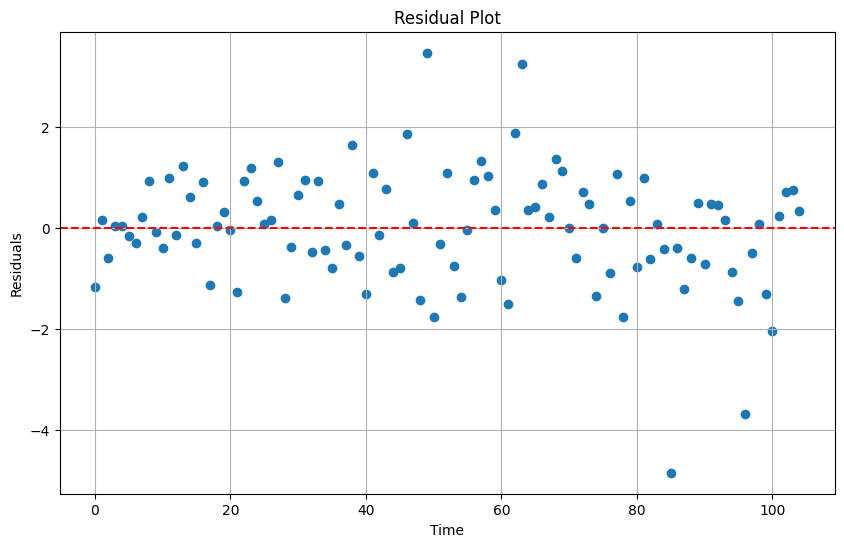

In [13]:
residuals = y_true - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


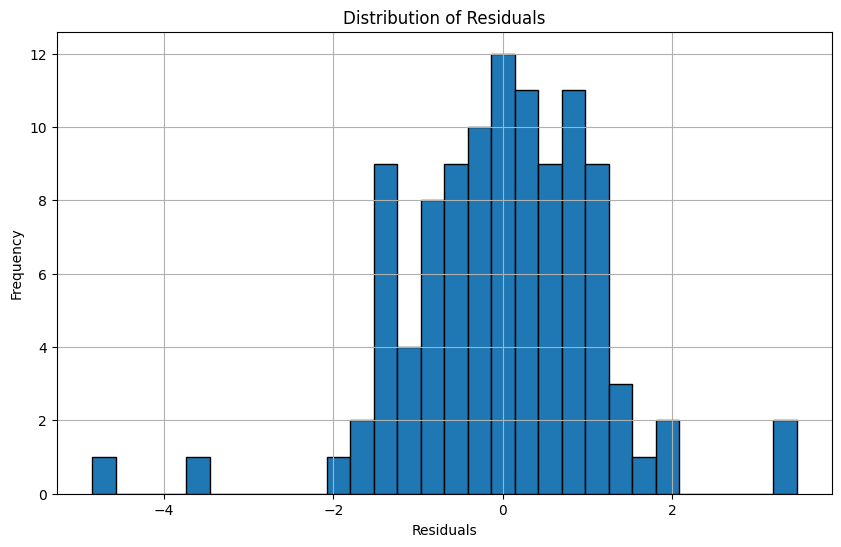

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
